In [1]:
from typing import Sequence

import torch
import copy
import os

import matplotlib.pyplot as plt

from torchcast.exp_smooth import ExpSmoother
from torchcast.utils.data import TimeSeriesDataset, TimeSeriesDataLoader

from tqdm.auto import tqdm

import numpy as np
import pandas as pd

# Using NN's for Long-Range Forecasts: Electricity Data

In this example we'll show how to handle complex series. The domain here -- electricity-usage data (using a dataset from the [UCI Machine Learning Data Repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014)) -- is a great example of a challenge for traditional forecasting applications. In these traditional approaches, we divide our model into siloed processes that each contribute to separate behaviors of the time-series. For example:

- Hour-in-day effects
- Day-in-week effects
- Season-in-year effects
- Weather effects

However, with electricity data, it's limiting to model these separately, because **these effects all interact**: the impact of hour-in-day depends on the day-of-week, the impact of the day-of-week depends on the season of the year, etc.

In [2]:
BASE_DIR = 'electricity'
SPLIT_DT = np.datetime64('2013-06-01')

## Data-Prep

In [3]:
try:
    df_elec = pd.read_csv(os.path.join(BASE_DIR, 'df_electricity.csv.gz'), parse_dates=['time'])
except FileNotFoundError as e:
    print(e)
    import requests
    from zipfile import ZipFile
    from io import BytesIO

    response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip')

    with ZipFile(BytesIO(response.content)) as f:
        df_raw = pd.read_table(f.open('LD2011_2014.txt'), sep=";", decimal=",")

    # melt from wide -> long; aggregate from every-15min to every hour
    df_elec = (df_raw
               .melt(id_vars=['dt'], value_name='kW', var_name='group')
               .assign(time=lambda df_elec: df_elec['dt'].dt.to_period('h').dt.to_timestamp())
               .groupby(['group', 'time'])
               ['kW'].mean()
               .reset_index())
    
    # find start time for each group:
    group_starts = df_elec[df_elec['kW'] > 0].groupby('group')['time'].min()
    
    # filter to start time:
    df_elec = (df_elec
               .loc[df_elec['time'] >= df_elec['group'].map(group_starts), :]
               .reset_index(drop=True))
    
    # from dataset documentation: "Every year in March time change day (which has only 23 hours) 
    # the values between 1:00 am and 2:00 am are zero for all points"
    zero_counts = df_elec.loc[df_elec['kW'] == 0,'time'].value_counts()
    df_elec.loc[df_elec['time'].isin(zero_counts.index[zero_counts>100]),'kW'] = float('nan')

    # Some groups have data that isn't really appropriate for modeling -- for example, exhibiting near-zero 
    # variation (e.g. MT_003). For some rudimentary cleaning, we'll remove these kinds of regions of flatness. 
    # For simplicity we'll just drop buildings that are flat in this way for a non-trivial amount of time.
    df_elec['roll_std'] = df_elec.groupby('group')['kW'].rolling(48).std().reset_index(0, drop=True)
    # set to missing when it's low
    df_elec.loc[df_elec.pop('roll_std') < .25, 'kW'] = float('nan')
    # drop groups with nontrivial amount of missings (for simplicity)
    group_missingness = df_elec.assign(missing=lambda df: df['kW'].isnull()).groupby('group')['missing'].mean()
    df_elec = df_elec.loc[df_elec['group'].map(group_missingness) < .01, :].reset_index(drop=True)

    # We'll split the data at mid-2013. For half the groups, the holdout will be used as validation data; for the other 
    # half, it will be used as test data.
    df_elec['_use_holdout_as_test'] = (df_elec['group'].str.replace('MT_', '').astype('int') % 2) == 0
    df_elec['dataset'] = 'train'
    df_elec.loc[(df_elec['time'] >= SPLIT_DT) & df_elec['_use_holdout_as_test'], 'dataset'] = 'test'
    df_elec.loc[(df_elec['time'] >= SPLIT_DT) & ~df_elec.pop('_use_holdout_as_test'), 'dataset'] = 'val'

    # drop groups without enough data:
    df_group_summary = (df_elec
                        .groupby(['group','dataset'])
                        ['time'].agg(['min', 'max'])
                        .reset_index()
                        .assign(history_len=lambda df: (df['max'] - df['min']).dt.days))
    
    all_groups = set(df_group_summary['group'])
    train_groups = sorted(df_group_summary.query("(dataset=='train') & (history_len >= 365)")['group'])
    df_elec = df_elec.loc[df_elec['group'].isin(train_groups), :].reset_index(drop=True)

    # inconveniently, there is only a single observation in 2015, which leads to annoyances later. just drop that one observation:
    assert (df_elec['time'].dt.year >= 2015).sum() <= df_elec['group'].nunique()
    df_elec = df_elec[df_elec['time'].dt.year < 2015].reset_index(drop=True)
        
    # save
    df_elec.to_csv(os.path.join(BASE_DIR, "df_electricity.csv.gz"), index=False)

np.random.seed(2024-10-4)
torch.manual_seed(2024-10-4)

Our dataset consists of hourly kW readings for multiple buildings:

In [4]:
df_elec.head()

,group,time,kW,dataset
0,MT_001,2012-01-01 00:00:00,3.172589,train
1,MT_001,2012-01-01 01:00:00,4.124365,train
2,MT_001,2012-01-01 02:00:00,4.758883,train
3,MT_001,2012-01-01 03:00:00,4.441624,train
4,MT_001,2012-01-01 04:00:00,4.758883,train


Let's pick an example group to focus on, for demonstrative purposes:

In [5]:
example_group = 'MT_358'

<Axes: xlabel='time'>

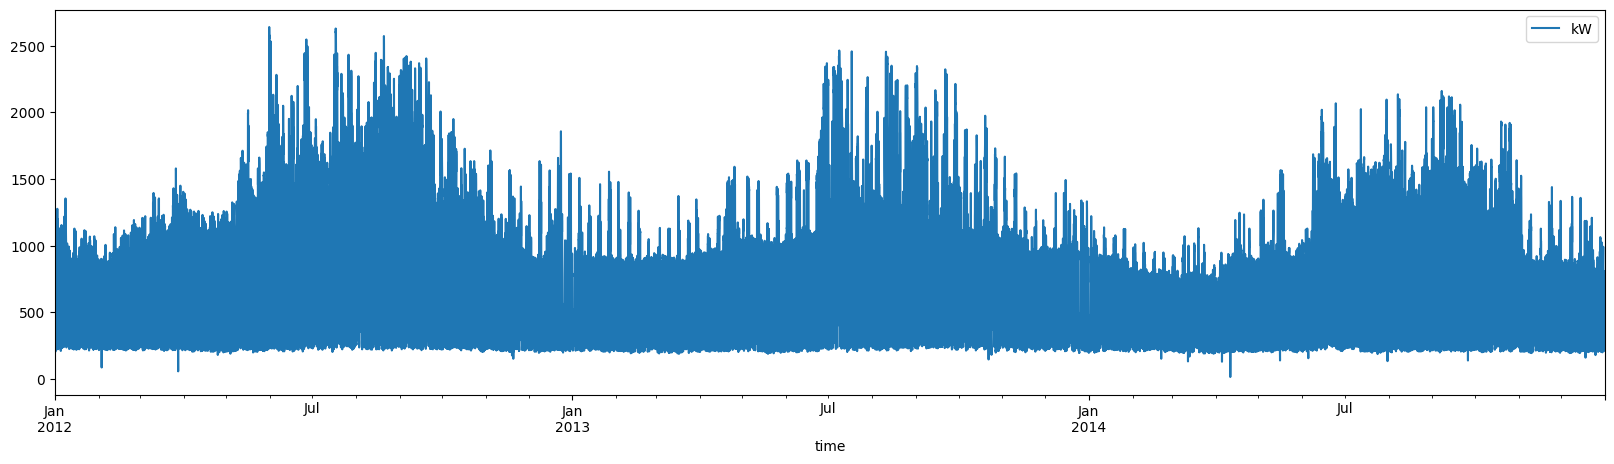

In [6]:
df_elec.query(f"group=='{example_group}'").plot('time', 'kW', figsize=(20, 5))

## A Standard Forecasting Approach

### Attempt 1

First, let's try a standard exponential-smoothing algorithm on one of the series.

In [7]:
from torchcast.process import LocalTrend, Season

es = ExpSmoother(
    measures=['kW_sqrt_c'],
    processes=[
        # seasonal processes:
        Season(id='day_in_week', period=24 * 7, dt_unit='h', K=3, fixed=True),
        Season(id='day_in_year', period=24 * 365.25, dt_unit='h', K=8, fixed=True),
        Season(id='hour_in_day', period=24, dt_unit='h', K=8, fixed=True),
        # long-running trend:
        LocalTrend(id='trend'),
    ]
)

In [8]:
# transform and center:
df_elec['kW_sqrt'] = np.sqrt(df_elec['kW'])
group_means = df_elec.query("dataset=='train'").groupby('group')['kW_sqrt'].mean().to_dict()
df_elec['kW_sqrt_c'] = df_elec['kW_sqrt'] - df_elec['group'].map(group_means) 

In [9]:
ds_example_building = TimeSeriesDataset.from_dataframe(
    df_elec.query("group == @example_group"),
    group_colname='group',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
)
ds_example_train, _ = ds_example_building.train_val_split(dt=SPLIT_DT)
ds_example_train

TimeSeriesDataset(sizes=[torch.Size([1, 12408, 1])], measures=(('kW_sqrt_c',),))

In [10]:
try:
    es.load_state_dict(torch.load(os.path.join(BASE_DIR, f"es_{example_group}.pt")))
except FileNotFoundError:
    es.fit(
        ds_example_train.tensors[0],
        start_offsets=ds_example_train.start_datetimes,
    )
    torch.save(es.state_dict(), os.path.join(BASE_DIR, f"es_{example_group}.pt"))

The first thing you'll notice about this approach is that it's **incredibly slow to train**. The second problem is that the forecasts are **terrible**:

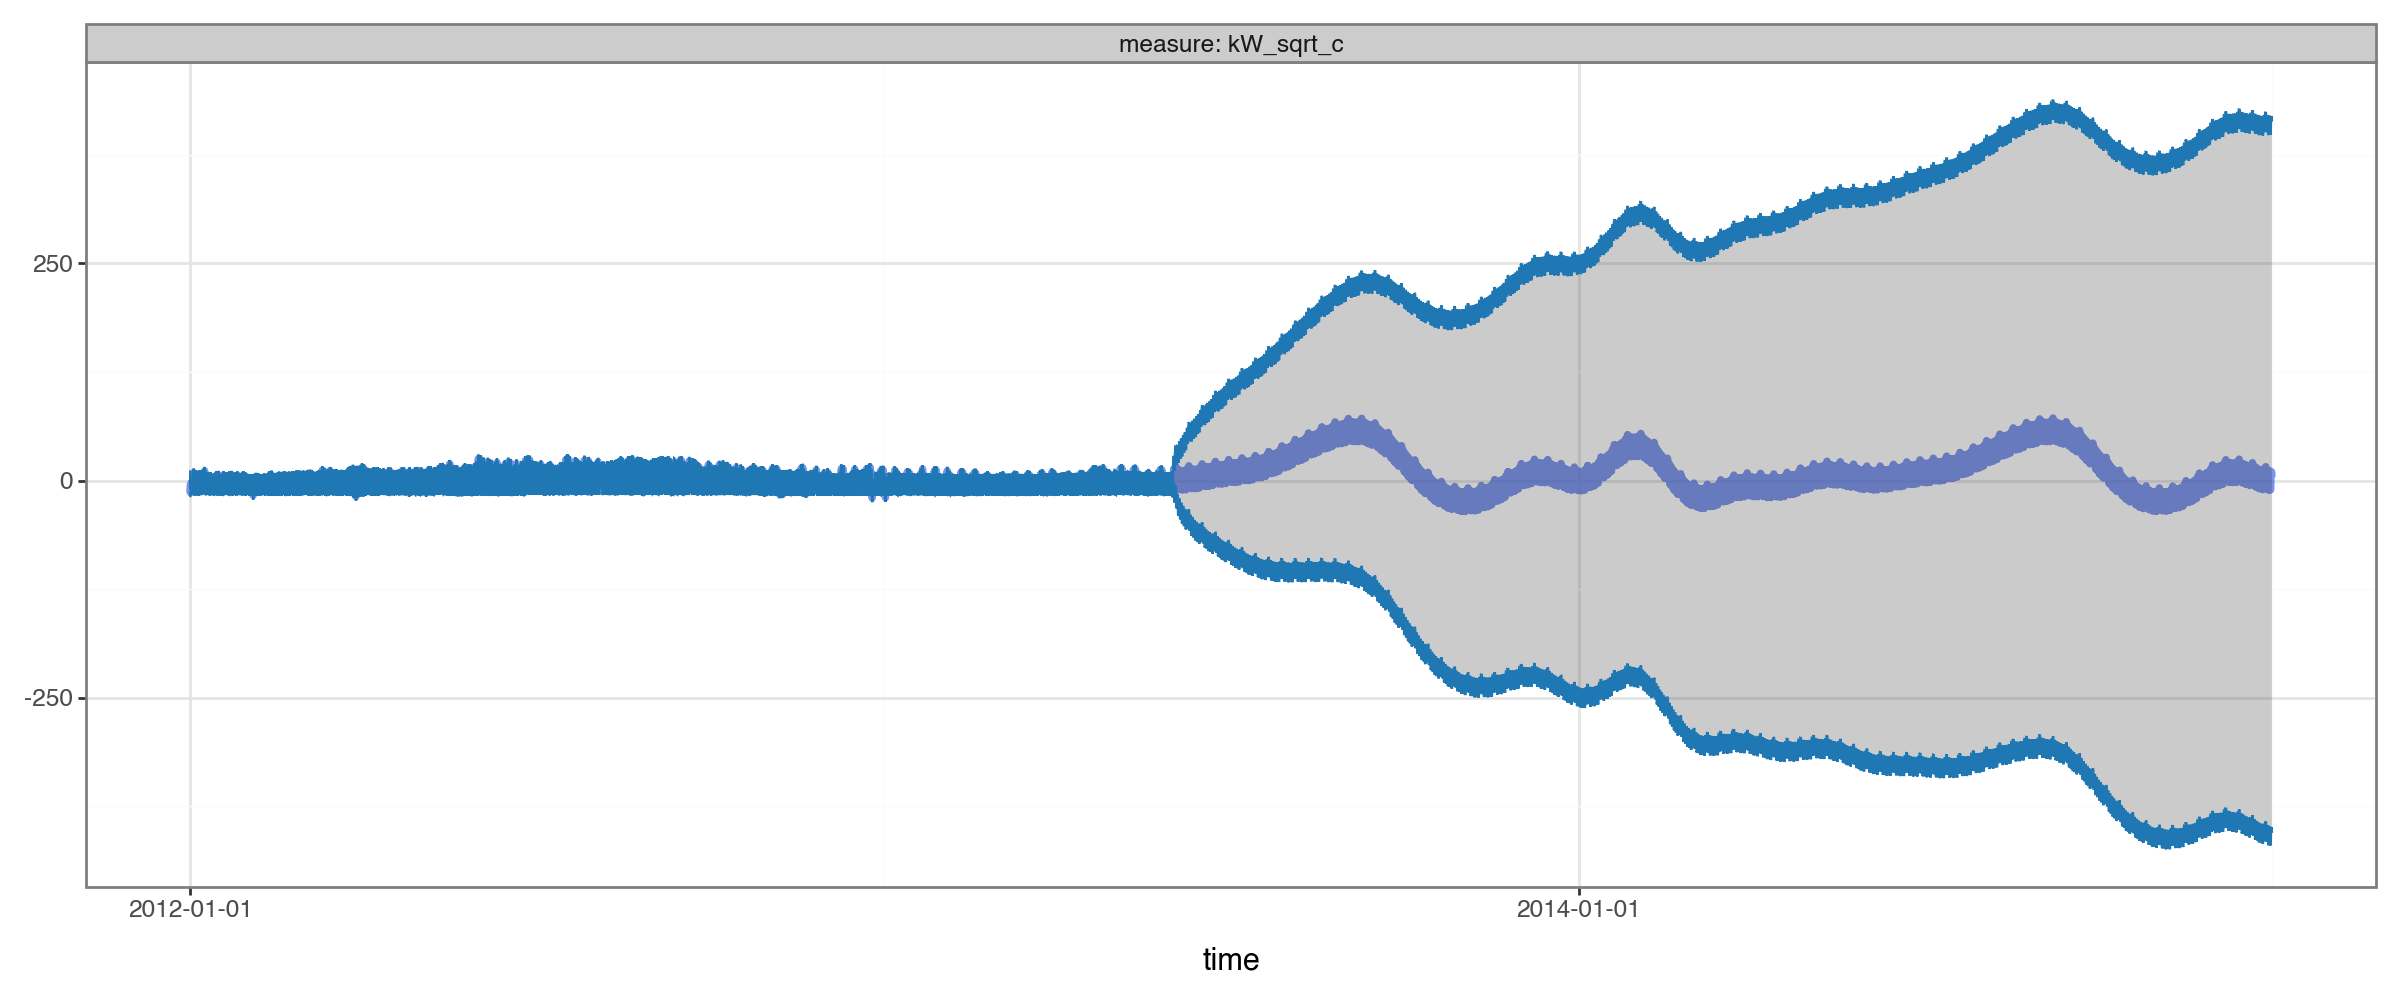

In [11]:
es_predictions = es(
    ds_example_train.tensors[0], 
    start_offsets=ds_example_train.start_datetimes,
    # note we *not* getting `num_timesteps` from `ds_example_train`, since we want to forecast outside the training time:
    out_timesteps=ds_example_building.num_timesteps 
)
es_predictions.plot()

The most obvious issue here is the discrepancy between the predictions on the training data (which look sane) and the validation data (which look insane). 

**This isn't overfitting, but instead the difference between one-step-ahead predictions vs. long-range forecasts.**

What's going on here? Part of the problem is that **the model wasn't actually trained to generate long-range forecasts.** The standard approach has us train on one-step-ahead predictions -- here, that means one *hour* ahead predictions.

### Attempt 2

Let's see if we can improve on this. We'll leave the model unchanged but make two changes:

- Use the `n_step` argument to train our model on one-week ahead forecasts, instead of one step (i.e. hour) ahead. This improves the efficiency of training by encouraging the model to 'care about' longer range forecasts vs. over-focusing on the easier problem of forecasting the next hour.
- Split our single series into multiple groups. This is helpful to speed up training, since pytorch has a non-trivial overhead for separate tensors: i.e., it scales well with an increasing batch-size (fewer, but bigger, tensors), but poorly with an increasing time-series length (smaller, but more, tensors).

In [12]:
def make_subgroup(df: pd.DataFrame) -> pd.Series:
    return df['group'] + ':' + df['time'].dt.year.astype('str') + ':' + df['time'].dt.quarter.astype('str')
df_elec['subgroup'] = make_subgroup(df_elec)
df_elec.head()

,group,time,kW,dataset,kW_sqrt,kW_sqrt_c,subgroup
0,MT_001,2012-01-01 00:00:00,3.172589,train,1.781176,-0.167091,MT_001:2012:1
1,MT_001,2012-01-01 01:00:00,4.124365,train,2.030853,0.082586,MT_001:2012:1
2,MT_001,2012-01-01 02:00:00,4.758883,train,2.181486,0.233219,MT_001:2012:1
3,MT_001,2012-01-01 03:00:00,4.441624,train,2.107516,0.159249,MT_001:2012:1
4,MT_001,2012-01-01 04:00:00,4.758883,train,2.181486,0.233219,MT_001:2012:1


In [13]:
ds_example_building2 = TimeSeriesDataset.from_dataframe(
    df_elec.query("group == @example_group"),
    group_colname='subgroup',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
)

ds_example_train2, _ = ds_example_building2.train_val_split(dt=SPLIT_DT, quiet=True)
# TODO: explain
ds_example_train2 = ds_example_train2[ds_example_train2.get_durations() > 1400]
ds_example_train2

TimeSeriesDataset(sizes=[torch.Size([6, 2208, 1])], measures=(('kW_sqrt_c',),))

In [14]:
es2 = ExpSmoother(
    measures=['kW_sqrt_c'],
    processes=[
        Season(id='day_in_week', period=24 * 7, dt_unit='h', K=3, fixed=True),
        Season(id='day_in_year', period=24 * 365.25, dt_unit='h', K=8, fixed=True),
        Season(id='hour_in_day', period=24, dt_unit='h', K=8, fixed=True),
        LocalTrend(id='trend'),
    ]
)

try:
    es2.load_state_dict(torch.load(os.path.join(BASE_DIR, f"es_{example_group}_2.pt")))
except FileNotFoundError:
    es2.fit(
        ds_example_train2.tensors[0],
        start_offsets=ds_example_train2.start_datetimes,
        n_step=int(24 * 7.5),
        every_step=False, # this speeds up training when n_step > 1
    )
    torch.save(es2.state_dict(), os.path.join(BASE_DIR, f"es_{example_group}_2.pt"))

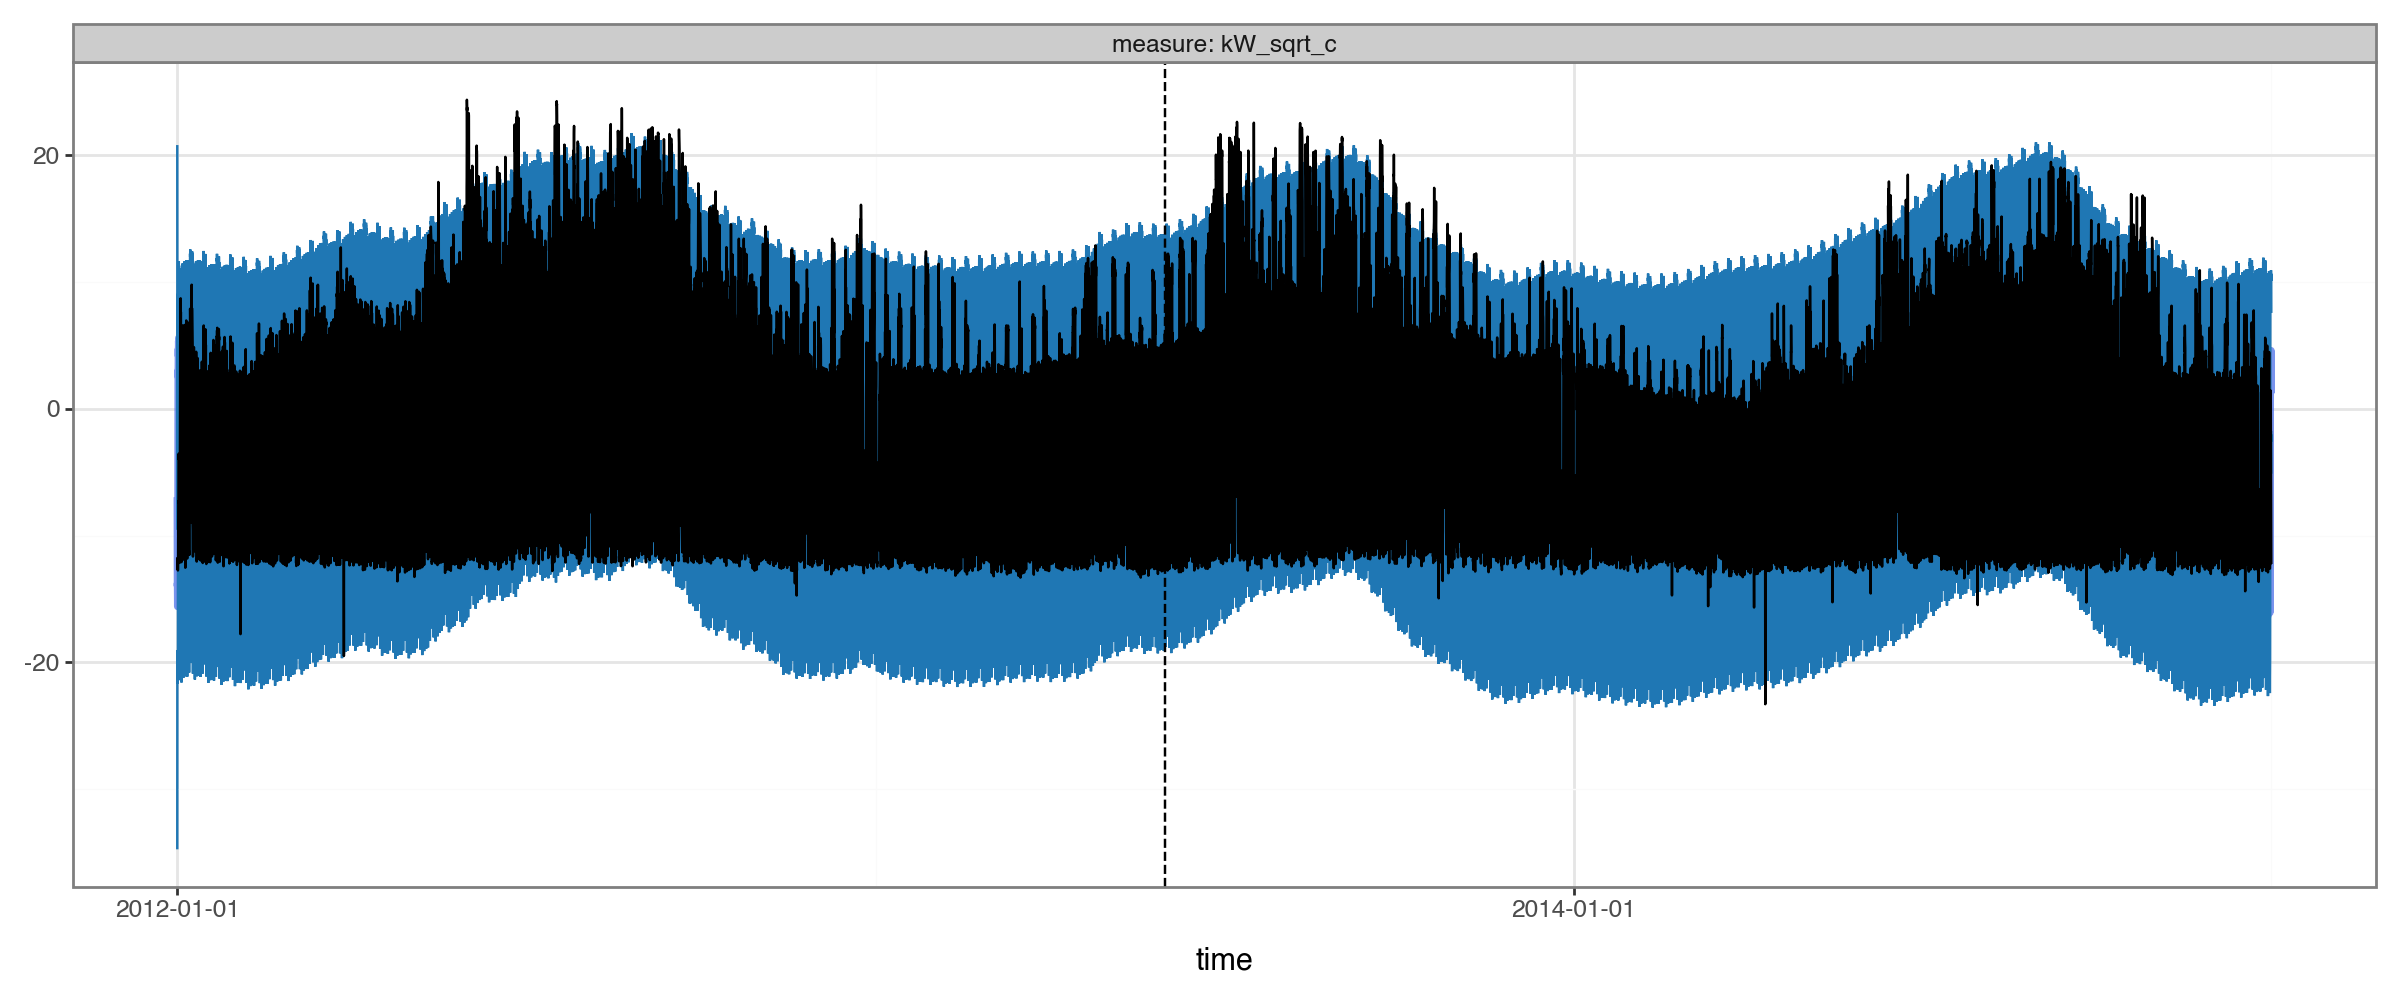

In [15]:
es2_predictions = es2(
    ds_example_train.tensors[0], 
    start_offsets=ds_example_train.start_datetimes,
    out_timesteps=ds_example_building.tensors[0].shape[1] # <---- TODO explain
)
es2_predictions.plot(es2_predictions.to_dataframe(ds_example_building), split_dt=SPLIT_DT)

Seems like a massive improvement... Unfortunately, with hourly data, visualizing long-range forecasts in this way isn't very illuminating: it's just really hard to see the data! 

We can try zooming in:

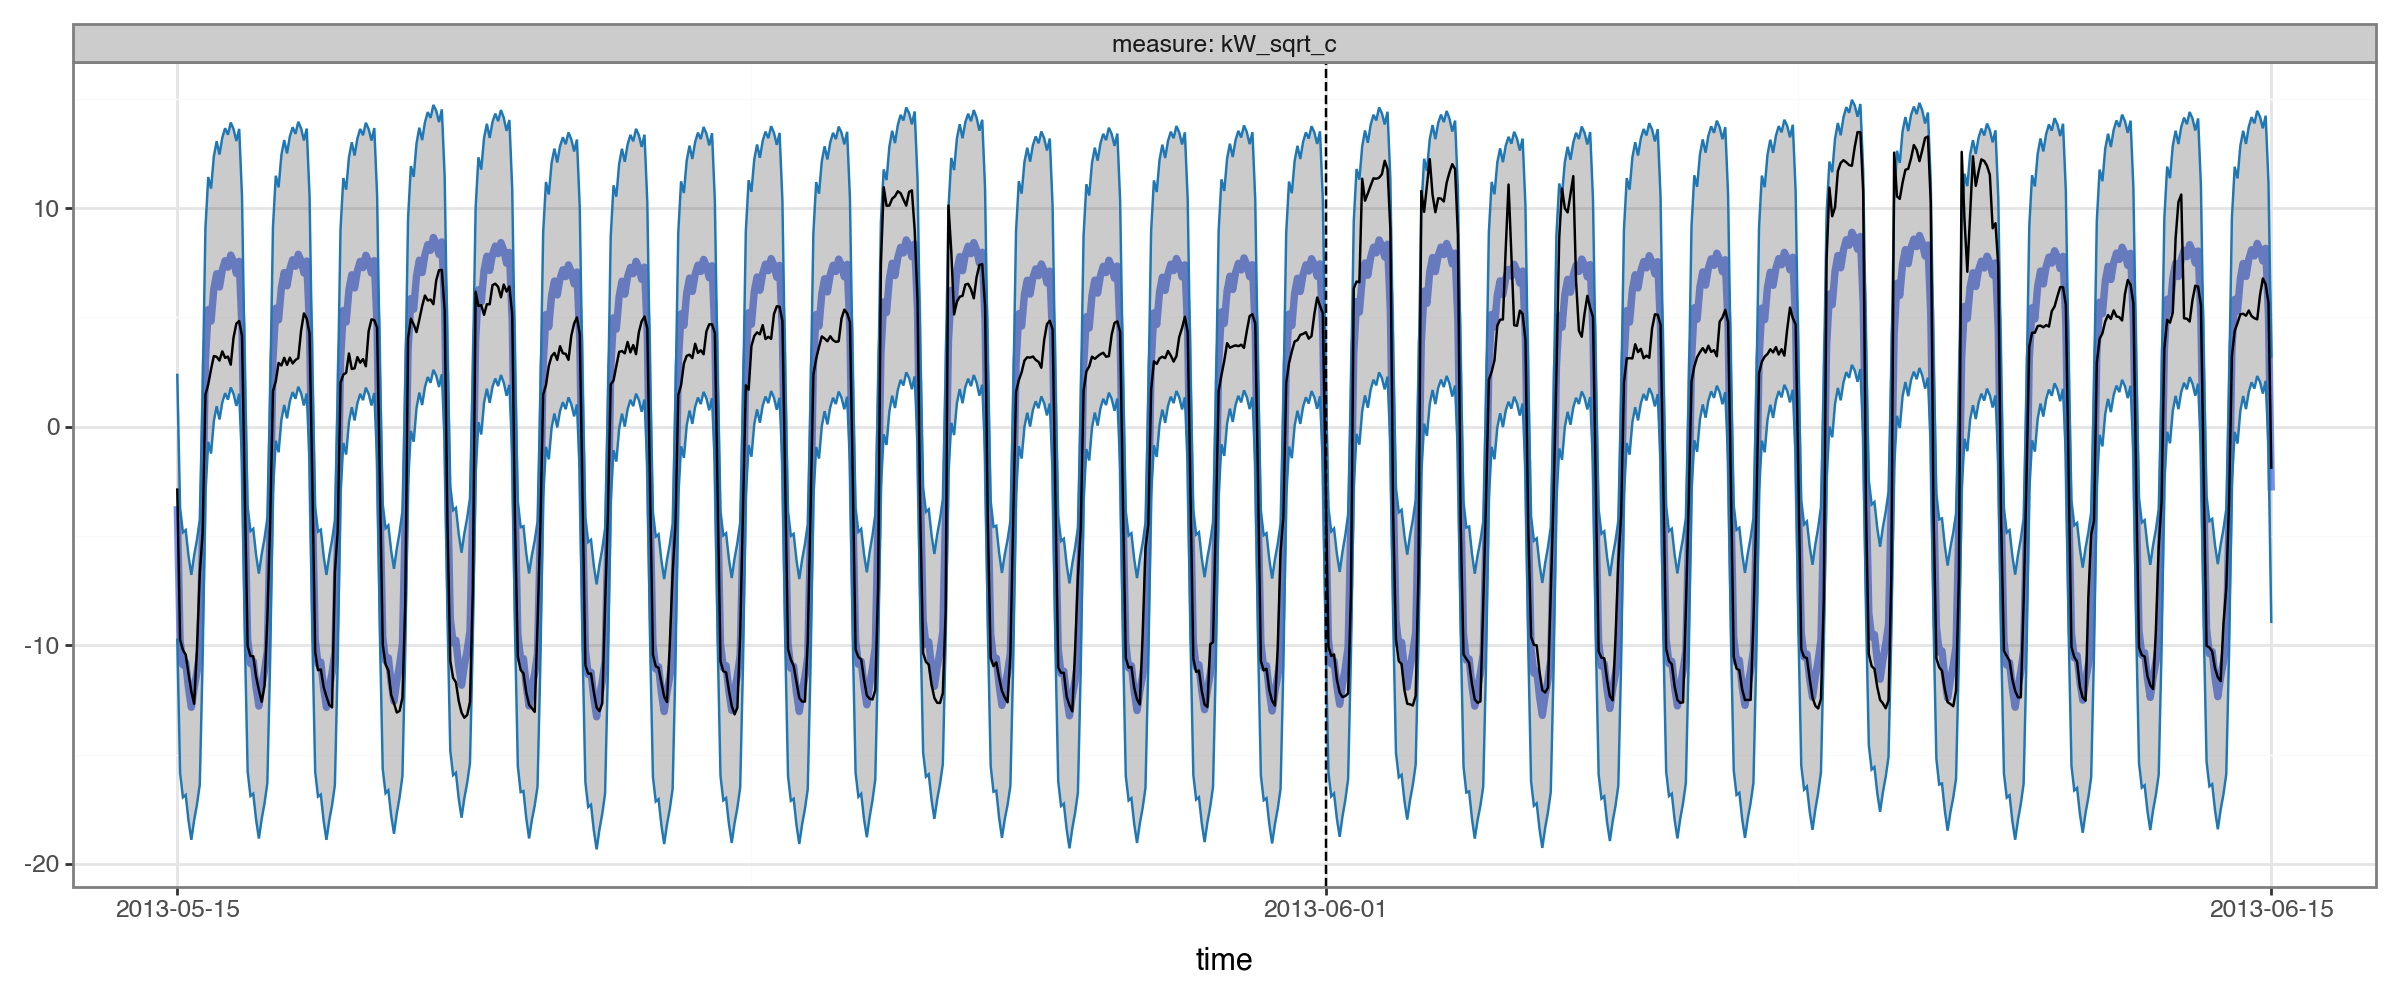

In [16]:
es2_predictions.plot(
    es2_predictions.to_dataframe(ds_example_building).query("time.between('2013-05-15', '2013-06-15')"),
    split_dt=SPLIT_DT
)

This is better for actually seeing the data, but ideally we'd still like to get a view of the long range. 

Let's instead try splitting it into weekdays vs. weekends and daytimes vs. nightimes:

In [17]:
def plot_2x2(df: pd.DataFrame,
             time_colname: str = 'time',
             pred_colname: str = 'mean',
             actual_colname: str = 'actual',
             day_hours: tuple = (14, 15, 16, 17, 18),
             night_hours: tuple = (2, 3, 4, 5, 6),
             **kwargs):
    """
    Plot predicted vs. actual for a single group, splitting into 2x2 facets of weekday/end * day/night.
    """

    df_split = (df.loc[df[time_colname].dt.hour.isin(day_hours) | df[time_colname].dt.hour.isin(night_hours), :]
                .assign(weekend=lambda df: df[time_colname].dt.weekday.isin([5, 6]).astype('int'),
                       night=lambda df: (df[time_colname].dt.hour.isin(night_hours)).astype('int'),
                       date=lambda df: df[time_colname].dt.normalize())
                .groupby(['date', 'weekend', 'night'])
                .agg(forecast=(pred_colname, 'mean'), 
                     actual=(actual_colname, 'mean'))
                .reset_index())
            
    kwargs['subplot_kw'] = kwargs.get('subplot_kw', {})
    if 'ylim' not in kwargs['subplot_kw']:
        kwargs['subplot_kw']['ylim'] = (df_split['actual'].min(), df_split['actual'].max())

    _, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), **kwargs)
    for (wknd, night), df in df_split.groupby(['weekend', 'night']):
        df.plot('date', 'actual', ax=axes[wknd, night], linewidth=.5, color='black')
        df.plot('date', 'forecast', ax=axes[wknd, night], alpha=.75, color='red')
        axes[wknd, night].axvline(x=SPLIT_DT, color='black', ls='dashed')
        axes[wknd, night].set_title("{}, {}".format('Weekend' if wknd else 'Weekday', 'Night' if night else 'Day'))
    plt.tight_layout()

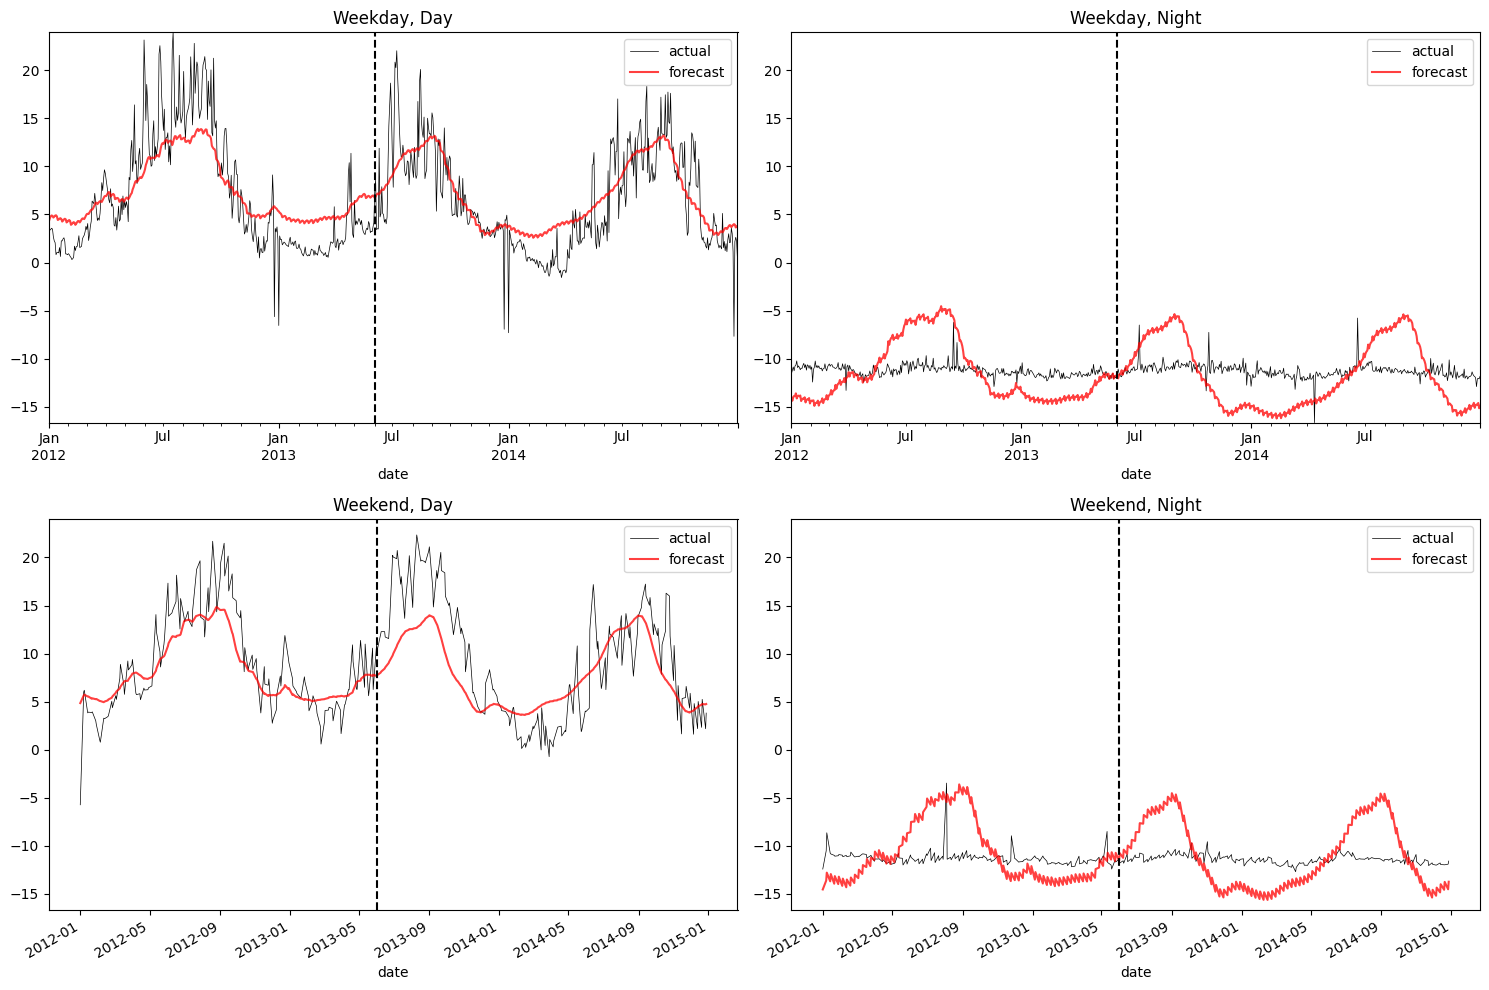

In [18]:
plot_2x2(es2_predictions.to_dataframe(ds_example_building))
#plt.show()

Viewing the forecasts in this way helps us see a lingering serious issue: the annual seasonal pattern is very different for daytimes and nighttimes, but the model isn't capturing that. 

The limitation is inherent to the model: it only allows for a single seasonal pattern, rather than a separate one for different times of the day and days of the week.

## Incorporating a Neural Network

We saw our time-series model wasn't allowing for interactions among the components of our time-series model. A natural solution to this is to incorporate a neural network -- learning arbitrary/complex interactions is exactly what they are for.

Of course, this requires scaling up our dataset: **we want to learn across multiple series, so that our network can build representations of patterns that are shared across multiple buildings.**

### Encoding Seasonlity as Fourier Terms

We're going to need to encode the seasonal cycles in our data into features that a neural-network can use as inputs.

There are multiple ways we can do this. For example, one option would be to extract each component of our datetimes and one-hot encode it:

In [19]:
(df_elec
 .loc[df_elec['group']==example_group,['time']]
 .assign(hod=lambda df: df['time'].dt.hour, dow=lambda df: df['time'].dt.dayofweek)
 .pipe(pd.get_dummies, columns=['hod', 'dow'], dtype='float')
 .head())

,time,hod_0,hod_1,hod_2,hod_3,hod_4,hod_5,hod_6,hod_7,hod_8,...,hod_21,hod_22,hod_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
9232450,2012-01-01 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9232451,2012-01-01 01:00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9232452,2012-01-01 02:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9232453,2012-01-01 03:00:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9232454,2012-01-01 04:00:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Instead, we'll use a different approach based on **fourier series**. Basically, we encoded our times into sin/cos waves. The number of waves is a hyper-parameter that can be tuned (though obviously there are natural upper-bounds: for weekly seasonality you don't need more that the days in the week) and helps us control how 'wiggly' we'll allow the seasons to be. For more reading on using fourier series for modeling seasonality, see [here](https://otexts.com/fpp2/useful-predictors.html#fourier-series) and [here](https://otexts.com/fpp2/complexseasonality.html#dynamic-harmonic-regression-with-multiple-seasonal-periods).

For visualization (and shortly, modeling), we'll use `torchcast`'s `add_season_features` function:

In [20]:
from torchcast.utils import add_season_features

df_elec = (df_elec
           .pipe(add_season_features, K=8, period='yearly')
           .pipe(add_season_features, K=3, period='weekly')
           .pipe(add_season_features, K=10, period='daily'))

yearly_season_feats = df_elec.columns[df_elec.columns.str.startswith('yearly_')].tolist()
weekly_season_feats = df_elec.columns[df_elec.columns.str.startswith('weekly_')].tolist()
daily_season_feats = df_elec.columns[df_elec.columns.str.startswith('daily_')].tolist()
season_feats = yearly_season_feats + weekly_season_feats + daily_season_feats

Let's visualize these waves:

<Axes: title={'center': 'Daily Fourier Terms'}, xlabel='time'>

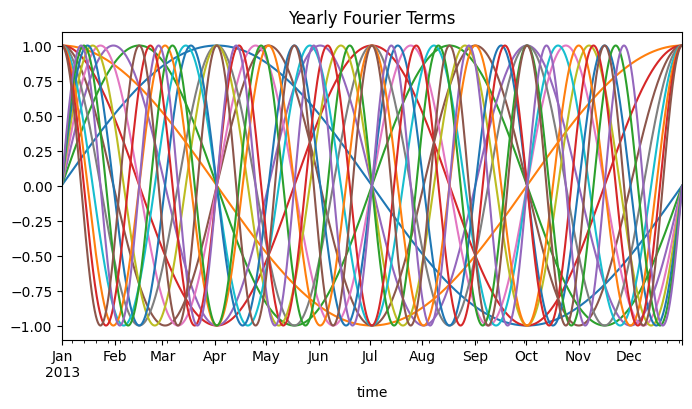

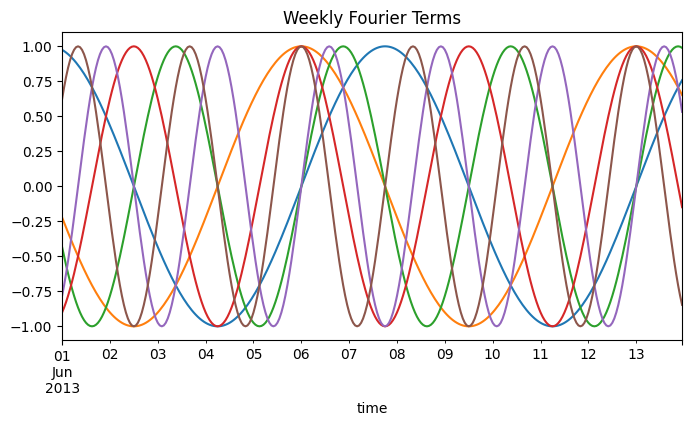

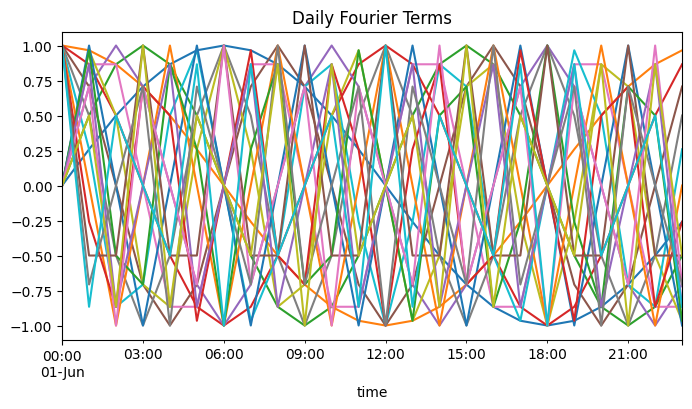

In [21]:
(df_elec
 .loc[df_elec['group'] == example_group, yearly_season_feats + ['time']]
 .query("time.dt.year == 2013")
 .plot(x='time', figsize=(8,4), legend=False, title='Yearly Fourier Terms'))

(df_elec
 .loc[df_elec['group'] == example_group, weekly_season_feats + ['time']]
 .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day < 14)")
 .plot(x='time', figsize=(8,4), legend=False, title='Weekly Fourier Terms'))

(df_elec
 .loc[df_elec['group'] == example_group, daily_season_feats + ['time']]
 .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day == 1)")
 .plot(x='time', figsize=(8,4), legend=False, title='Daily Fourier Terms'))

### Step 1: Pre-Training a Seasonal-Embeddings NN

For this task, we'll switch from exponential smoothing (with `ExpSmoother`) to a full state-space model (with `KalmanFilter`). This is because only the latter can learn relationships specific to each time-series.

The `LinearModel` provides a catch-all for any way of passing arbitrary inputs to our model. For example, if we had weather data -- temperature, humidity, wind-speed -- we might add a process like:

```
LinearModel(id='weather', predictors=['temp','rhumidity','windspeed'])
```

And our time-series model would learn how each of these impacts our series(es).

Here we are using `LinearModel` a little differently: rather than it taking as input predictors, it will take as input the *output* of a neural-network, which itself will take predictors (the calendar-features we just defined).

What we'd like to do is train a neural network to embed the seasonality (as represented by our fourier terms) into a lower dimensional space, then we'll pass that lower dimensional representation onto our KalmanFilter/LinearModel, which will learn how each time-series behaves in relation to that space. Basically, we are reducing the dozens of calendar-features (and their hundreds of interactions) into an efficient low-dimensional representation.

For this purpose, `torchcast` provides the `SeasonalEmbeddingsTrainer` class:

In [22]:
from torchcast.utils.training import SeasonalEmbeddingsTrainer

SEASON_EMBED_NDIM = 12

season_embedder = torch.nn.Sequential(
    torch.nn.LazyLinear(out_features=48),
    torch.nn.Tanh(),
    torch.nn.Linear(48, 48),
    torch.nn.Tanh(),
    torch.nn.Linear(48, SEASON_EMBED_NDIM, bias=False)
)

season_trainer = SeasonalEmbeddingsTrainer(
    module=season_embedder,
    yearly=8,
    weekly=3,
    daily=10
)

/Users/jacobdink/miniconda3/envs/bark-phone/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


Again, the number of embedding dimensions is a hyper-parameter, where we trade off computational efficiency for precision.

Since we'll be training on the whole dataset instead of just one example building, we'll switch from a `TimeSeriesDataset` to a `TimeSeriesDataLoader`, which lets us iterate over the whole dataset in a training loop:

In [23]:
season_dl = TimeSeriesDataLoader.from_dataframe(
    df_elec.query("dataset=='train'"),
    group_colname='group',
    time_colname='time',
    dt_unit='h',
    measure_colnames=['kW_sqrt_c'],
    batch_size=45 # fairly even batch sizes
)

Let's use our trainer to train `season_embedder`:

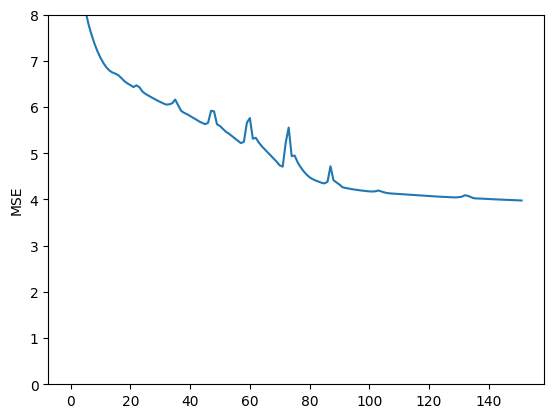

In [24]:
try:
    _path = os.path.join(BASE_DIR, f"season_trainer{SEASON_EMBED_NDIM}.pt")
    season_trainer = torch.load(_path)
    season_embedder = season_trainer.module
    plt.plot(season_trainer.loss_history)
    plt.ylim(0, 8)
    plt.ylabel('MSE')
    plt.show()
    
except FileNotFoundError as e:
    from IPython.display import clear_output
    
    #season_trainer.loss_history = []
    for loss in season_trainer(season_dl):
        season_trainer.loss_history.append(loss)
    
        # plot:
        clear_output(wait=True)
        plt.plot(season_trainer.loss_history)
        plt.ylim(0, 8)
        plt.ylabel('MSE')
        plt.show()
    
        # stop after converges (in our case, about 150 iterations):
        if len(season_trainer.loss_history) > 150:
            break

    torch.save(_path)

Let's visualize the output of this neural network, with each color being a separate output:

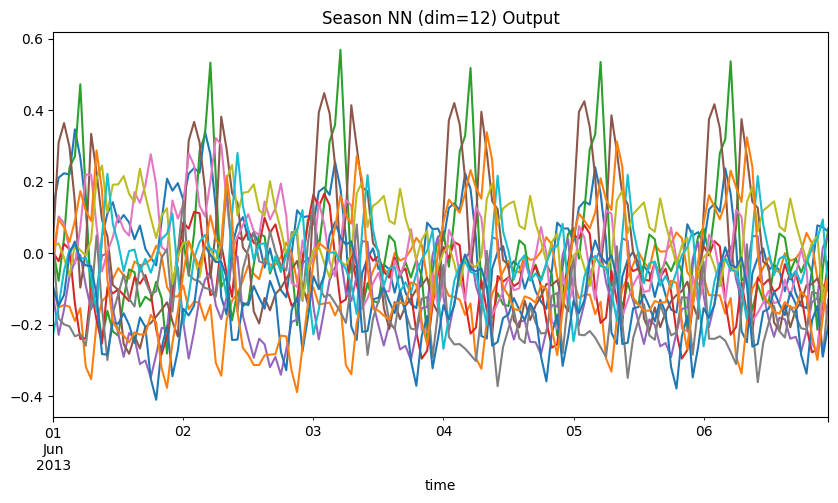

In [25]:
with torch.no_grad():
    times = ds_example_building.times().squeeze()
    pred = season_trainer.module(season_trainer.times_to_model_mat(times).to(torch.float))
    (pd.DataFrame(pred.numpy())
         .assign(time=times)
         .query("(time.dt.year == 2013) & (time.dt.month == 6) & (time.dt.day < 7)")
         .plot(x='time', figsize=(10,5), legend=False, title=f'Season NN (dim={SEASON_EMBED_NDIM}) Output'))

You can think of each colored line as equivalent to the sin/cos waves above; but now, instead of dozens of these, we have far fewer, that should *hopefully* be able to capture interacting seasonal effects.

But is that hope founded in anything? Let's see if our embeddings are able to capture what we want for our example building.

The season-trainer lets us pass these outputs through a linear-model, to visualize how these embeddings can be used to predict the actual series values:

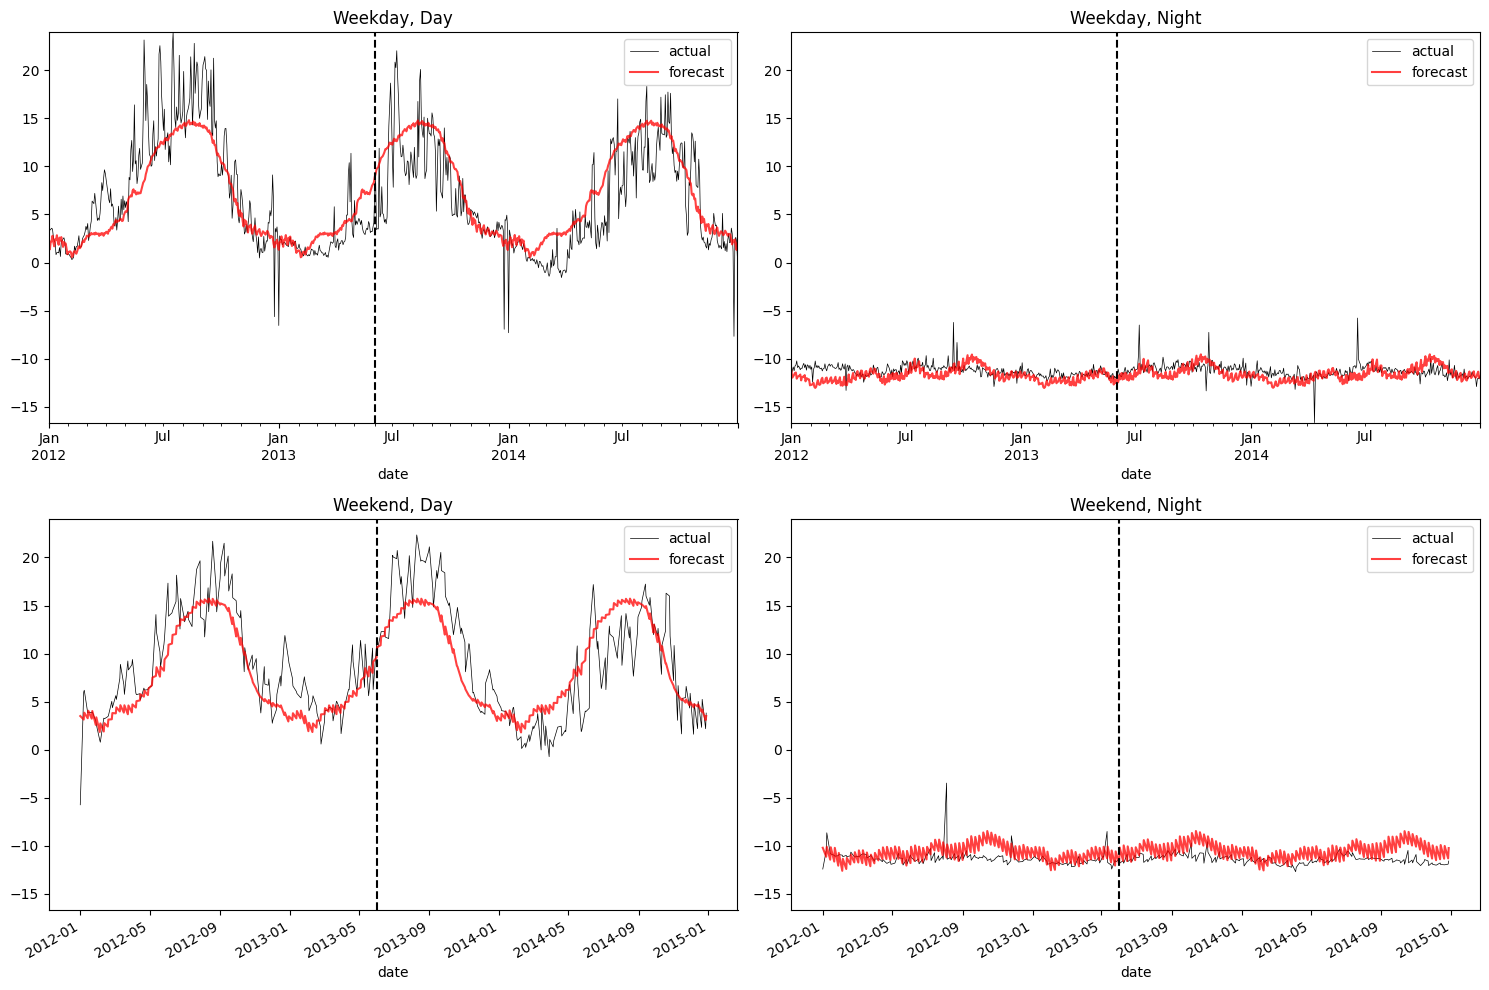

In [26]:
with torch.no_grad():
    (ds_example_building
     .to_dataframe()
     .assign(pred=season_trainer.predict(ds_example_building).squeeze())
     .pipe(plot_2x2, actual_colname='kW_sqrt_c', pred_colname='pred'))
plt.show()

Success! We now have different seasonal patterns depending on the time of the day.

### Step 2: Incorporate our Seasonal-Embeddings into our Time-Series Model

How should we incorporate our `season_embedder` neural-network into a state-space model? 

One simple option is just to leverage the util methods in the `SeasonalEmbeddingsTrainer`, which handles converting a `TimeSeriesDataset` into a tensor of fourier terms:

```python
class SeasonNNKalmanFilter(KalmanFilter):
    def __init__(self, season_trainer: SeasonalEmbeddingsTrainer, **kwargs):
        super().__init__(**kwargs)
        self.season_trainer = season_trainer
        self.add_module('season_nn', season_trainer.module)

    def forward(self,
                batch: 'TimeSeriesDataset',
                **kwargs) -> Predictions:
        X = self.season_trainer.times_to_model_mat(batch.times())
        return super().forward(batch.tensors[0], X=self.season_nn(X), **kwargs)

kf_nn = KalmanFilter(
    measures=['kW_sqrt_c'],
    processes=[
        LinearModel(id='nn_output', predictors=[f'nn{i}' for i in range(SEASON_EMBED_NDIM)]),
        LocalTrend(id='trend'),
    ]
)
```

However, we'll use a somewhat more generalizable approach that shows how you can add arbitrary predictors to a `TimeSeriesDataLoader`.

We already have our fourier terms added to the main `df_elec` dataframe, so we can just pass those via `X_colnames`:

In [27]:
dataloaderX = TimeSeriesDataLoader.from_dataframe(
    df_elec.query("dataset=='train'"),
    group_colname='subgroup',
    time_colname='time',
    dt_unit='h',
    y_colnames=['kW_sqrt_c'],
    X_colnames=season_feats,
    batch_size=50 
)

Now we'll set up our model. Note we are setting up the LinearModel to take the neural network *outputs* as its own *inputs*:

In [28]:
from torchcast.kalman_filter import KalmanFilter
from torchcast.process import LinearModel

kf_nn = KalmanFilter(
    measures=['kW_sqrt_c'],
    processes=[
        LinearModel(id='nn_output', predictors=[f'nn{i}' for i in range(SEASON_EMBED_NDIM)]),
        LocalTrend(id='trend'),
    ]
)
kf_nn.season_embedder = season_embedder # register the module

For this notebook, we'll just use a simple trainer, but you might consider more feature-robust tools like Pytorch Lightning for other applications:

In [29]:
def _make_kf_nn_kwargs(batch: 'TimeSeriesDataset') -> dict:
    return {
        'X' : kf_nn.season_embedder(batch.tensors[1]),
        'n_step' : int(24 * 7.5),
        'every_step' : False
    }

In [30]:
from torchcast.utils.training import StateSpaceTrainer
ss_trainer = StateSpaceTrainer(
    module=kf_nn, 
    kwargs_getter=_make_kf_nn_kwargs
)

But wait: if we're just passing the outputs of `season_embedder` to our time-series model, why did we bother pre-training `season_embedder`? In fact, `torchcast` _does_ support end to end modeling, so in principle we could pass use a completely untrained neural-network here. 

In practice, neural-networks have many more parameters and take many more epochs than our state-space models (and conversely, our state-space models are much slower to train _per_ epoch). So it's much more efficient to pre-train the network first. Then it's up to us whether we want to continue training the network, or just freeze its weights (i.e. exclude it from the optimizer) and just train the state-space models' paramters.

In [ ]:
try:
    _path = os.path.join(BASE_DIR, f"kf_nn{SEASON_EMBED_NDIM}.pt")
    kf_nn = torch.load(_path)
except FileNotFoundError as e:
    from IPython.display import clear_output
    
    ss_trainer.loss_history = []
    for loss in ss_trainer(dataloaderX):
        ss_trainer.loss_history.append(loss)
        print(loss)
    
        # TODO
        if len(ss_trainer.loss_history) > 100:
            break

    torch.save(ss_trainer, _path)

  0%|          | 0/50 [00:00<?, ?it/s]

2.700634106508354
2.608272926271513


In [ ]:
with torch.inference_mode():
    dataloader_all = TimeSeriesDataLoader.from_dataframe(
        # importantly, we'll set to `nan` our target when it's outside the training dates
        # this allows us to use `season_feats` in the forecast period, while not having data-leakage
        df_elec.assign(kW_sqrt_c=lambda df: df['kW_sqrt_c'].where(df['dataset']=='train')), 
        group_colname='group',
        time_colname='time',
        dt_unit='h',
        y_colnames=['kW_sqrt_c'],
        X_colnames=season_feats,
        batch_size=50 
    )
    
    df_all_preds = []
    for batch in tqdm(dataloader_all):
        y, X = batch.tensors
        df_all_preds.append(
            kf_nn(y, X=season_embedder(X), start_offsets=batch.start_offsets)
            .to_dataframe(batch)
            .drop(columns=['actual'])
        )
df_all_preds = pd.concat(df_all_preds).reset_index(drop=True)
df_all_preds

# END

In [ ]:
foo = df_all_preds.merge(df_elec.query("group==@example_group"))
plot_2x2(foo, actual_colname='kW_sqrt_c')

In [ ]:
from torchcast.process import LinearModel, LocalLevel

es_nn = ExpSmoother(
    measures=['kW_sqrt_c'],
    processes=[
        # trend:
        LocalTrend(id='trend'),
        # static seasonality:
        LinearModel(id='season', predictors=['nn_output']),
        # local deviations from typical behavior:
        LocalLevel(id='local_level', decay=True),
        Season(id='local_hour_in_day', period=24, dt_unit='h', K=6, decay=True),
    ]
)

#### Evaluation

Reviewing the same example-building from before, we see the forecasts are more closely hewing to the actual seasonal structure for each time of day/week. Instead of the forecasts in each panel being essentially identical, each differs in shape. 

In [ ]:
es_nn_lightning.to(maybe_cuda)
df_forecast_nn = []
with torch.no_grad():
    for _batch in make_dataloader('all', batch_size=25):
        _batch = _batch.to(maybe_cuda)
        forecast_batch = _batch.with_new_tensors(
            _batch.train_val_split(dt=SPLIT_DT)[0].tensors[0],
            _batch.tensors[1]
        )
        forecast_nn = es_nn_lightning(forecast_batch, out_timesteps=_batch.tensors[1].shape[1])
        df_forecast_nn.append(forecast_nn.to_dataframe(_batch))
df_forecast_nn = pd.concat(df_forecast_nn).query("actual.notnull()", engine='python').reset_index(drop=True)

In [ ]:
plot_forecasts(df_forecast_nn.query("group==@example_group & time.dt.year==2013 & time.dt.month==6"))

In [ ]:
plot_2x2(df_forecast_nn.query("group==@example_group"))

Let's confirm quantitatively that the 2nd model does indeed substantially reduce forecast error, relative to the 'standard' model:

In [ ]:
def inverse_transform(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ['mean', 'lower', 'upper', 'actual']:
        df[col] = df[col] + df['group'].map(group_means)
        df[col] = df[col].clip(lower=0) ** 2
    return df

In [ ]:
df_nn_err = df_forecast_nn. \
    pipe(inverse_transform).\
    assign(error=lambda df: (df['mean'] - df['actual']).abs(),
           validation=lambda df: df['time'] > SPLIT_DT). \
    groupby(['group', 'validation']). \
    agg(error=('error', 'mean')). \
    reset_index()

df_forecast_ex2. \
    pipe(inverse_transform).\
    assign(error=lambda df: (df['mean'] - df['actual']).abs(),
           validation=lambda df: df['time'] > SPLIT_DT). \
    groupby(['group', 'validation']). \
    agg(error=('error', 'mean')). \
    reset_index(). \
    merge(df_nn_err, on=['group', 'validation'], suffixes=('_es', '_es_nn'))